In [2]:
%load_ext autoreload
%autoreload 2

# SETUP

In [5]:
import sys
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
import torch
#import torch.nn as nn # basic building blocks of neural networks
import torchvision.transforms as T
from IPython.display import HTML, display
from matplotlib import pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from tqdm import tqdm

from sklearn.metrics import confusion_matrix # for evaluating the model of a single pixel basis

from max import locate_data, load_data

pd.set_option("display.max_columns", None)

assert sys.version_info >= (
    3,
    10,
), "This notebook requires at least Python 3.10"

# DATA LOADING

In [8]:
DATA_DIR = Path("../data/CamVid/")

img_height = 720
img_width = 960

In [9]:
class_lables, X_train_paths, y_train_paths, X_test_paths, y_test_paths, X_val_paths, y_val_paths = locate_data(DATA_DIR)

class_lables.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
name,Animal,Archway,Bicyclist,Bridge,Building,Car,CartLuggagePram,Child,Column_Pole,Fence,LaneMkgsDriv,LaneMkgsNonDriv,Misc_Text,MotorcycleScooter,OtherMoving,ParkingBlock,Pedestrian,Road,RoadShoulder,Sidewalk,SignSymbol,Sky,SUVPickupTruck,TrafficCone,TrafficLight,Train,Tree,Truck_Bus,Tunnel,VegetationMisc,Void,Wall
r,64,192,0,0,128,64,64,192,192,64,128,192,128,192,128,64,64,128,128,0,192,128,64,0,0,192,128,192,64,192,0,64
g,128,0,128,128,0,0,0,128,192,64,0,0,128,0,64,192,64,64,128,0,128,128,128,0,64,64,128,128,0,192,0,192
b,64,128,192,64,0,128,192,64,128,128,192,64,64,192,64,128,0,128,192,192,128,128,192,64,64,128,0,192,64,0,0,0


In [10]:
# Load data into memory
X_train = load_data(X_train_paths)
y_train = load_data(y_train_paths)

assert (
    type(X_train[0][0][0][0]) == np.uint8
), "image is not stored as unit8 dtype"  # PyTorch likes uint8

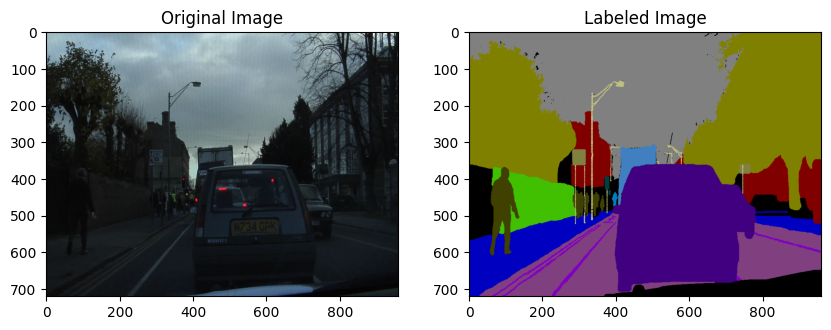

In [11]:
# Show a sample image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
img_idx = 0
ax1.set_title("Original Image")
ax1.imshow(X_train[img_idx])

ax2.set_title("Labeled Image")
ax2.imshow(y_train[img_idx])
plt.show()

In [12]:
# Prep data for pytorch
training_batch_size = 20

train_loader = DataLoader(dataset=X_train, batch_size=training_batch_size)

# MODEL DEV

Intersection over Union (IoU) -> commonly used evaluation metric for supervised semantic image segmentation tasks.

In [13]:
SMOOTH = 1e-6 # To avoid division by zero

def iou(model_output: torch.Tensor, label: torch.Tensor) -> float:
    """Calculate the IoU for a single model output and label pair."""
    intersection = (
        (model_output & label).float().sum((1, 2))
    )  # Will be zero if Truth=0 or Prediction=0
    union = (model_output | label).float().sum((1, 2))  # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # smooth division to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.7), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch


def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W

    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.7), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  # Or thresholded.mean() if you are interested in average across the batch

Training process:
1. calc loss
2. calc gradient
3. update weights
4. repeat